In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from evoscape.module_helper_functions import modules_from_txt
from evoscape.landscapes import CellDiff_Dataset_Landscape
import evoscape.landscape_visuals as vis
from evoscape.morphogen_regimes import mr_piecewise
from matplotlib.colors import ListedColormap, BoundaryNorm, CenteredNorm, Normalize
import cmcrameri.cm as cm
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from matplotlib import colormaps
from matplotlib import style
style.use('default')

In [2]:

plt.rcParams.update({'figure.dpi': 200})  # Change to 200 for high res figures
plt.rcParams.update({'font.size': 15})  
plt.rcParams['axes.grid'] = False

%load_ext autoreload


In [3]:
data_dir = '../alfyn_results_stage2/saved_files_8/CellDiff_Dataset_Landscape/'
file_name = data_dir + 'optimization_log.csv'

log = pd.read_csv(file_name, sep='\t', names=['Timecode', 'Init timecode', 'Fitness'], skiprows=1)
print(log.shape)

fitness_threshold = -0.5505
n_landscapes = np.sum(log['Fitness'] > fitness_threshold)
print(n_landscapes)
timecodes = log['Timecode'][log['Fitness'] > fitness_threshold]


def landscape_from_timecode(timecode, data_dir, gen, landscape_pars):
    filename = data_dir + timecode + '/' + timecode + '_module_list_' + str(gen) + '.txt'
    with open(filename, 'r') as f:
        module_list = modules_from_txt(filename)
    landscape = CellDiff_Dataset_Landscape(module_list, A0=landscape_pars['A0'], regime=mr_piecewise, n_regimes=5)
    return landscape

landscape_pars = {
    'A0': 0.005,
}
gen = 300

(241, 3)
60


In [4]:
def transform_coords(module_list, old_coords, origin=0, direction=2, left=None, right=None, bottom=None, scale=False):
    module_coords = np.zeros((len(module_list), 2))
    for i, module in enumerate(module_list):
        module_coords[i, :] = module.x, module.y
    coords = old_coords - module_coords[origin]   # move origin 
    module_coords = module_coords - module_coords[origin]
    
    # x, y = np.mean(module_coords[direction, 0]), np.mean(module_coords[direction, 1])
    norm_coords = (module_coords.T/np.linalg.norm(module_coords, axis=1).T).T
    x, y = np.sum(norm_coords[direction, 0]), np.sum(norm_coords[direction, 1])

    d = np.linalg.norm((x, y))  
    R = np.array([[x, y], [-y, x]])/d
    coords = (R @ coords.T).T  # rotate to align with direction module
    module_coords = (R @ module_coords.T).T
    
    if bottom is not None:
        if module_coords[bottom, 1] > 0:    # flip the y-axis if needed
            coords[:, 1] *= -1.
    if left is not None:
        if module_coords[left, 0] > 0:     # flip the x-axis if needed
            coords[:, 0] *= -1.
    if right is not None:
        if module_coords[right, 0] < 0:     # flip the x-axis if needed
            coords[:, 0] *= -1.
            
    if scale:
        coords /= np.max(np.abs(coords))
        
    return coords

In [5]:
def rotate_landscape(landscape, origin=0, direction=2, left=None, right=None, bottom=None):
    module_coords = np.zeros((len(landscape.module_list), 2))
    for i, module in enumerate(landscape.module_list):
        module_coords[i, :] = module.x, module.y
    x0 = np.zeros((1, 2))
    x0 -= module_coords[origin]
    module_coords = module_coords - module_coords[origin]
    
    # x, y = np.mean(module_coords[direction, 0]), np.mean(module_coords[direction, 1])
    
    norm_coords = (module_coords.T/np.linalg.norm(module_coords, axis=1).T).T
    x, y = np.sum(norm_coords[direction, 0]), np.sum(norm_coords[direction, 1])
    
    d = np.linalg.norm((x, y))  
    R = np.array([[x, y], [-y, x]])/d
    x0 = (R @ x0.T).T
    module_coords = (R @ module_coords.T).T
    
    if bottom is not None:
        if module_coords[bottom, 1] > 0:    # flip the y-axis if needed
            module_coords[:, 1] *= -1.
            x0[0, 1] *= -1.
    if left is not None:
        if module_coords[left, 0] > 0:     # flip the x-axis if needed
            module_coords[:, 0] *= -1.
            x0[0, 0] *= -1.
    if right is not None:
        if module_coords[right, 0] < 0:     # flip the x-axis if needed
            module_coords[:, 0] *= -1.
            x0[0, 0] *= -1.
    for i, module in enumerate(landscape.module_list):
        module.x, module.y = module_coords[i, :]
    landscape.x0 = x0[0]
    
    return landscape
        
            

In [6]:
colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')
    
def pars_from_timecode(timecode, data_dir, gen):
    par_names = []
    par_colors = []
    filename = data_dir + timecode + '/' + timecode + '_module_list_' + str(gen) + '.txt'
    with open(filename, 'r') as f:
        module_list = modules_from_txt(filename)
    
    n_modules = len(module_list) 
    
    coords = np.zeros((n_modules, 2))
    for i in range(n_modules):
        module = module_list[i]
        coords[i] = module.x, module.y
    pars = []
    
    # Epi - AN - CE
    origin = 0 
    direction = (5,2)
    right = None
    left = None
    bottom = 4
    
    
    # CE + PN/M !
    origin = 2
    direction = (3,4)
    right = None
    bottom = 4
    left = 0
    coords = transform_coords(module_list, coords, origin=origin, direction=direction, left=left, right=right, bottom=bottom)
    
    for i in range(6):
        par_names.append('M'+str(i)+' x')
        par_colors.append(colors[i])
        pars.append(coords[i, 0])

        par_names.append('M'+str(i)+' y')
        pars.append(coords[i, 1])
        par_colors.append(colors[i])

    for i in (2,3,4):
        module = module_list[i]
        pars.extend(module.a[0:])
        for j in range(0, len(module.a)):
            par_names.append('M'+str(i)+' a'+ str(j))
            par_colors.append(colors[i])
            
    for i in (2,3,4):
        module = module_list[i]
        pars.extend(module.s[0:])
        for j in range(0, len(module.s)):
            par_names.append('M'+str(i)+' s'+ str(j))
            par_colors.append(colors[i])
    
    return np.array(pars), par_names, par_colors

['M0 x', 'M0 y', 'M1 x', 'M1 y', 'M2 x', 'M2 y', 'M3 x', 'M3 y', 'M4 x', 'M4 y', 'M5 x', 'M5 y', 'M2 a0', 'M2 a1', 'M2 a2', 'M2 a3', 'M2 a4', 'M3 a0', 'M3 a1', 'M3 a2', 'M3 a3', 'M3 a4', 'M4 a0', 'M4 a1', 'M4 a2', 'M4 a3', 'M4 a4', 'M2 s0', 'M2 s1', 'M2 s2', 'M2 s3', 'M2 s4', 'M3 s0', 'M3 s1', 'M3 s2', 'M3 s3', 'M3 s4', 'M4 s0', 'M4 s1', 'M4 s2', 'M4 s3', 'M4 s4']


/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_29659/3633556127.py:9: RuntimeWarning: invalid value encountered in divide
  norm_coords = (module_coords.T/np.linalg.norm(module_coords, axis=1).T).T


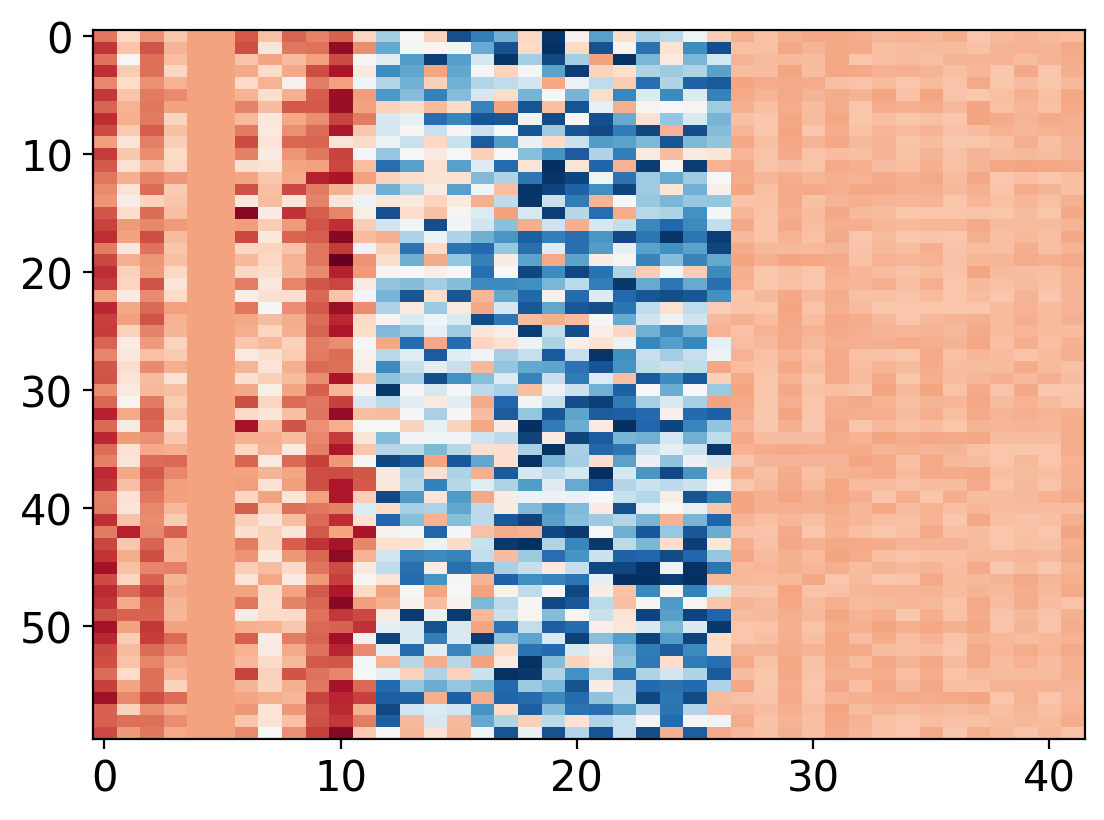

In [7]:
all_pars = np.zeros((n_landscapes, 2*6 + 3*2*5))   

for i, timecode in enumerate(timecodes):
    # print(timecode)
    all_pars[i, :], par_names, par_colors = pars_from_timecode(timecode, data_dir, gen)
    
print(par_names)
plt.imshow(all_pars, cmap='RdBu', aspect=0.5)
plt.show()

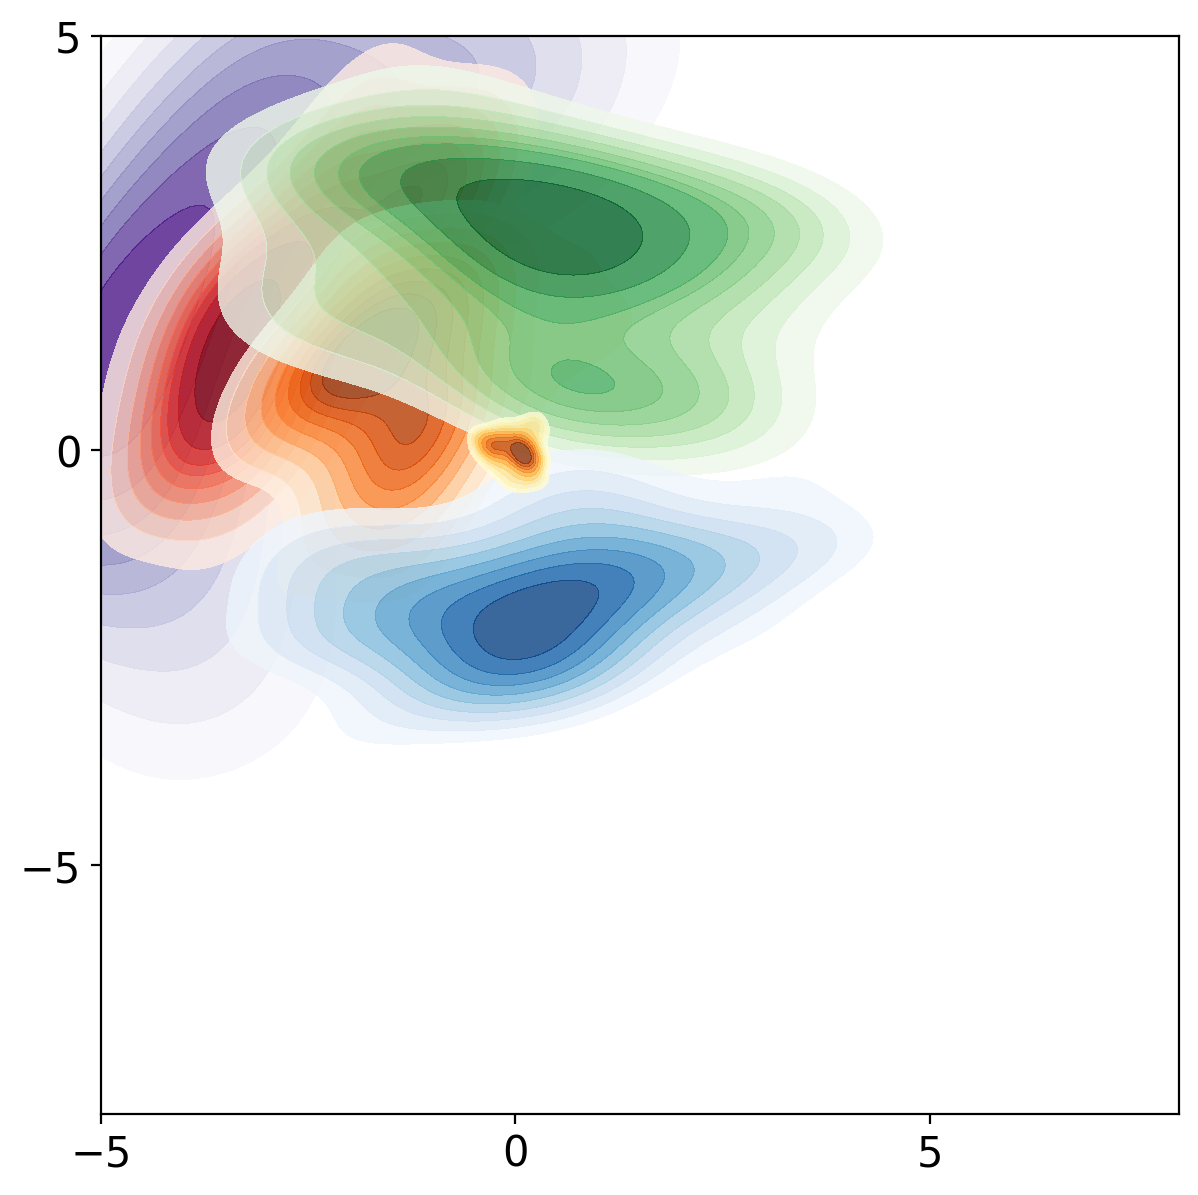

In [8]:
fig, ax = plt.subplots(figsize=(7,7))


# Epi - AN - CE decision
# sns.kdeplot(x=all_pars[:, 6], y=all_pars[:, 7], cmap='Greens', fill=True, alpha=0.4, thresh=0.2)
# sns.kdeplot(x=all_pars[:, 8], y=all_pars[:, 9], cmap='Blues', fill=True, alpha=0.4, thresh=0.2)
# sns.kdeplot(x=all_pars[:, 2], y=all_pars[:, 3], cmap='Oranges', fill=True, alpha=0.9, thresh=0.2)
# sns.kdeplot(x=all_pars[:, 4], y=all_pars[:, 5], cmap='YlOrBr', fill=True, alpha=0.9, thresh=0.2)
# sns.kdeplot(x=all_pars[:, 10], y=all_pars[:, 11], cmap='Purples', fill=True, alpha=0.9, thresh=0.2)
# sns.kdeplot(x=0.25*np.random.randn(n_landscapes), y=0.25*np.random.randn(n_landscapes), cmap='Reds', fill=True, alpha=0.9, thresh=0.2)
# _________________________________________
# plt.scatter(all_pars[:, 6], y=all_pars[:, 7], c=colors[3], s=30, marker='D', alpha=0.4, edgecolors='None', zorder=0)
# plt.scatter(all_pars[:, 8], y=all_pars[:, 9], c=colors[4], s=30, marker='D', alpha=0.4, edgecolors='None', zorder=0)

# CE - PN - M decision
sns.kdeplot(x=all_pars[:, 10], y=all_pars[:, 11], cmap='Purples', fill=True, alpha=0.8, thresh=0.2)
sns.kdeplot(x=all_pars[:, 0], y=all_pars[:, 1], cmap='Reds', fill=True, alpha=0.8, thresh=0.2)
sns.kdeplot(x=all_pars[:, 2], y=all_pars[:, 3], cmap='Oranges', fill=True, alpha=0.8, thresh=0.2)
sns.kdeplot(x=all_pars[:, 6], y=all_pars[:, 7], cmap='Greens', fill=True, alpha=0.8, thresh=0.2)
sns.kdeplot(x=all_pars[:, 8], y=all_pars[:, 9], cmap='Blues', fill=True, alpha=0.8, thresh=0.2)
sns.kdeplot(x=0.25*np.random.randn(n_landscapes), y=0.25*np.random.randn(n_landscapes), cmap='YlOrBr', fill=True, alpha=0.8, thresh=0.2)
# ________________________________________
# sns.kdeplot(x=all_pars[:, 6], y=all_pars[:, 7], cmap='Greens', fill=True, alpha=0.4, thresh=0.2)
# sns.kdeplot(x=all_pars[:, 8], y=all_pars[:, 9], cmap='Blues', fill=True, alpha=0.4, thresh=0.2)
# sns.kdeplot(x=all_pars[:, 10], y=all_pars[:, 11], cmap='Purples', fill=True, alpha=0.9, thresh=0.2)
# sns.kdeplot(x=all_pars[:, 0], y=all_pars[:, 1], cmap='Reds', fill=True, alpha=0.9, thresh=0.2)
# sns.kdeplot(x=all_pars[:, 2], y=all_pars[:, 3], cmap='Oranges', fill=True, alpha=0.9, thresh=0.2)
# sns.kdeplot(x=0.25*np.random.randn(n_landscapes), y=0.25*np.random.randn(n_landscapes), cmap='YlOrBr', fill=True, alpha=0.9, thresh=0.2)

# plt.scatter(all_pars[:, 0], y=all_pars[:, 1], c=colors[0], s=30, marker='D', alpha=0.4, edgecolors='None', zorder=0)
# plt.scatter(all_pars[:, 2], y=all_pars[:, 3], c=colors[1], s=30, marker='D', alpha=0.4, edgecolors='None', zorder=0)
# plt.scatter(all_pars[:, 10], y=all_pars[:, 11], c=colors[5], s=30, marker='D', alpha=0.4, edgecolors='None', zorder=0)



plt.ylim((-8,4))
plt.xlim((-4, 8))
plt.xticks((-5,0,5))
plt.yticks((-5,0,5))

ax.set_aspect('equal')
plt.show()

In [10]:
%autoreload

L = 4.
npoints = 201
q = np.linspace(-L, L, npoints)
xx, yy = np.meshgrid(q,q, indexing = 'xy')

noise = 0.2
ndt = 50
nt = 61
ncells = 300


init_state = 2

delta=2.
morphogen_times = (delta*1, delta*3, delta*7, delta*7)
time_pars = (0, delta*7, nt)


morphogen_times = (delta*0, delta*1.5, delta*7, delta*7)
time_pars = (0, delta*3, nt)

n_landscapes = len(timecodes)
# n_landscapes = 5
Q = np.zeros((n_landscapes, nt*ncells*2))


for i in range(n_landscapes):
    # print(i)
    timecode = timecodes.iloc[i]
    landscape = landscape_from_timecode(timecode, data_dir, gen, landscape_pars)
    landscape.morphogen_times = morphogen_times

    landscape.init_cells(ncells, init_state, noise/5)
    traj, states = landscape.run_cells(*time_pars, noise, ndt=ndt, frozen=False)
    
    data = traj.transpose(1,2,0).reshape(-1, 2)
    # fig, ax = vis.visualize_cell_states(landscape, xx, yy, t, 0)
    # ax.scatter(data[:,0], data[:, 1], color='k', alpha=0.3, marker='.', s=5)
    # plt.show()
        
    st_data = transform_coords(landscape.module_list, data, origin=2, direction=(3, 4), left=None, right=4, bottom=4, scale=True)
    # scaler = StandardScaler()
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # st_data = scaler.fit_transform(data)
    
    # fig, ax = plt.subplots(1,1, figsize=(4,4))
    # ax.scatter(st_data[:,0], st_data[:, 1], cmap='viridis', c=range(data.shape[0]), alpha=0.3, marker='.', s=5)
    # plt.show()

    
    flat_data = st_data.flatten()
    Q[i] = flat_data
        


/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:272: RuntimeWarning: divide by zero encountered in divide
  -np.sum((coordinate.T - np.array((module.x, module.y))) ** 2, axis=1) / 2. / st ** 2) / st ** 2
/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:271: RuntimeWarning: invalid value encountered in divide
  prob[:, i] = np.exp(
/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)
/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_79396/3633556127.py:9: RuntimeWarning: invalid value encountered in divide
  norm_coords = (module_coords.T/np.linalg.norm(module_coords, axis=1).T).T


KeyboardInterrupt: 

In [46]:
n_components = 15  # Number of principal components to retain
pca = PCA(n_components=n_components)
pca_transformed = pca.fit_transform(Q)

# Reconstruct data from PCA components
Q_reconstructed = pca.inverse_transform(pca_transformed)

# Reshape back to original trajectory shape (n_landscapes, nt, ncells, 2)
Q_reconstructed = Q_reconstructed.reshape(n_landscapes, -1, 2)
Q_original = Q.reshape(n_landscapes, -1, 2)


# Print explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)




Explained variance ratio: [0.23730439 0.20527493 0.04292619 0.02589395 0.02304179 0.02196845
 0.02017478 0.019628   0.01923531 0.01815117 0.01792179 0.01667026
 0.01597142 0.0153608  0.01501836]


In [9]:

num_samples = 50
sample_indices = np.random.choice(n_landscapes, num_samples, replace=False)
sample_indices = np.arange(num_samples)

# for idx, i in enumerate(sample_indices):
#     plt.figure(figsize=(2.5, 2.5))
#     plt.scatter(Q_original[i][:, 0], Q_original[i][:, 1], c='b', label="Original", marker='.', s = 5)
#     plt.xlabel("X")
#     plt.ylabel("Y")
#     # plt.legend()
#     plt.title(f"Trajectory {i}")
#     plt.xlim((-1, 1))
#     plt.ylim((-1, 1))
#     ax = plt.gca()
#     ax.set_aspect('equal')
# plt.tight_layout()
# plt.show()

Q_original = Q.reshape(n_landscapes, -1, 2)


# plt.figure(figsize=(6, 6))
for idx, i in enumerate(sample_indices):
    
    data = Q_original[i][:, 0:2]
    
    # eps = 0.1
    # db = DBSCAN(eps=eps, min_samples=15)
    # labels = db.fit_predict(data)
    
    # gmm = GaussianMixture(n_components=3, random_state=42)
    # labels = gmm.fit_predict(data)
    
    
    x_bins = np.linspace(-1, 1, 21)
    density, x_edges, y_edges = np.histogram2d(data[:, 0], data[:, 1], bins=[x_bins, x_bins])
    density_mask = density.T>10
    bin_centers = (x_bins[:-1] + x_bins[1:]) / 2
    X, Y = np.meshgrid(bin_centers, bin_centers)

    
    
    x, y = data[:, 0], data[:, 1]
    # x = X[density_mask]
    # y = Y[density_mask]
    r2 = np.sqrt(x**2 + y**2)
    x_sorted = np.sort(x)
    mask1 = (y < 0) * (r2>0.0)
    mask2 = (y >= 0) * (r2>0.0)

    # coeffs1 = np.polyfit(x[mask1], y[mask1], 1, w=r2[mask1])
    coeffs1 = np.polyfit(x[mask1], y[mask1], 1, w=None)
    error1 = np.sum((np.polyval(coeffs1, x[mask1]) - y[mask1])** 2)
    # coeffs2 = np.polyfit(x[mask2], y[mask2], 1, w=r2[mask2])
    coeffs2 = np.polyfit(x[mask2], y[mask2], 1, w=None)
    error2 = np.sum((np.polyval(coeffs2, x[mask2]) - y[mask2]) ** 2, )
    print(np.mean((error1, error2)))
    
    plt.figure(figsize=(2.5, 2.5))
    plt.scatter(Q_original[i][:, 0], Q_original[i][:, 1], label="Original", marker='.', s = 5, alpha=0.2, c='k')    
    # plt.scatter(X[density_mask], Y[density_mask], label="Original", marker='.', s = 5, alpha=1, c='b')    
    
    line1 = np.polyval(coeffs1, x_sorted)
    line2 = np.polyval(coeffs2, x_sorted)
    plt.plot(x_sorted[line1<0], line1[line1<0], 'r-')
    plt.plot(x_sorted[line2>0], line2[line2>0], 'g-')
    
    
    
    
    # plt.scatter(Q_original[i][:, 0], Q_original[i][:, 1], label="Original", marker='.', s = 5, alpha=0.2, c=labels, cmap='viridis')  
    # plt.scatter(Q_reconstructed[i][:, 0], Q_reconstructed[i][:, 1], c='r', label="Reconstructed", marker='.', s = 5)

    # hull = ConvexHull(data)
    # for simplex in hull.simplices:
    #     plt.plot(data[simplex, 0], data[simplex, 1], 'r-', lw=1)

    # plt.scatter(Q_reconstructed[i][:, 0], Q_reconstructed[i][:, 1], c='r', label="Reconstructed", marker='.', s = 5)
    plt.xlabel("X")
    plt.ylabel("Y")
    # plt.legend()
    plt.title(f"Trajectory {i}")
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()


NameError: name 'Q' is not defined

58


/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:272: RuntimeWarning: divide by zero encountered in divide
  -np.sum((coordinate.T - np.array((module.x, module.y))) ** 2, axis=1) / 2. / st ** 2) / st ** 2
/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:271: RuntimeWarning: invalid value encountered in divide
  prob[:, i] = np.exp(
/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)
/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_29659/3633556127.py:9: RuntimeWarning: invalid value encountered in divide
  norm_coords = (module_coords.T/np.linalg.norm(module_coords, axis=1).T).T
/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_29659/289758969.py:11: RuntimeWarning: invalid value encountered in divide
  norm_coords = (module_coords.T/np.linalg.norm(module_coords, axis=1).T).T


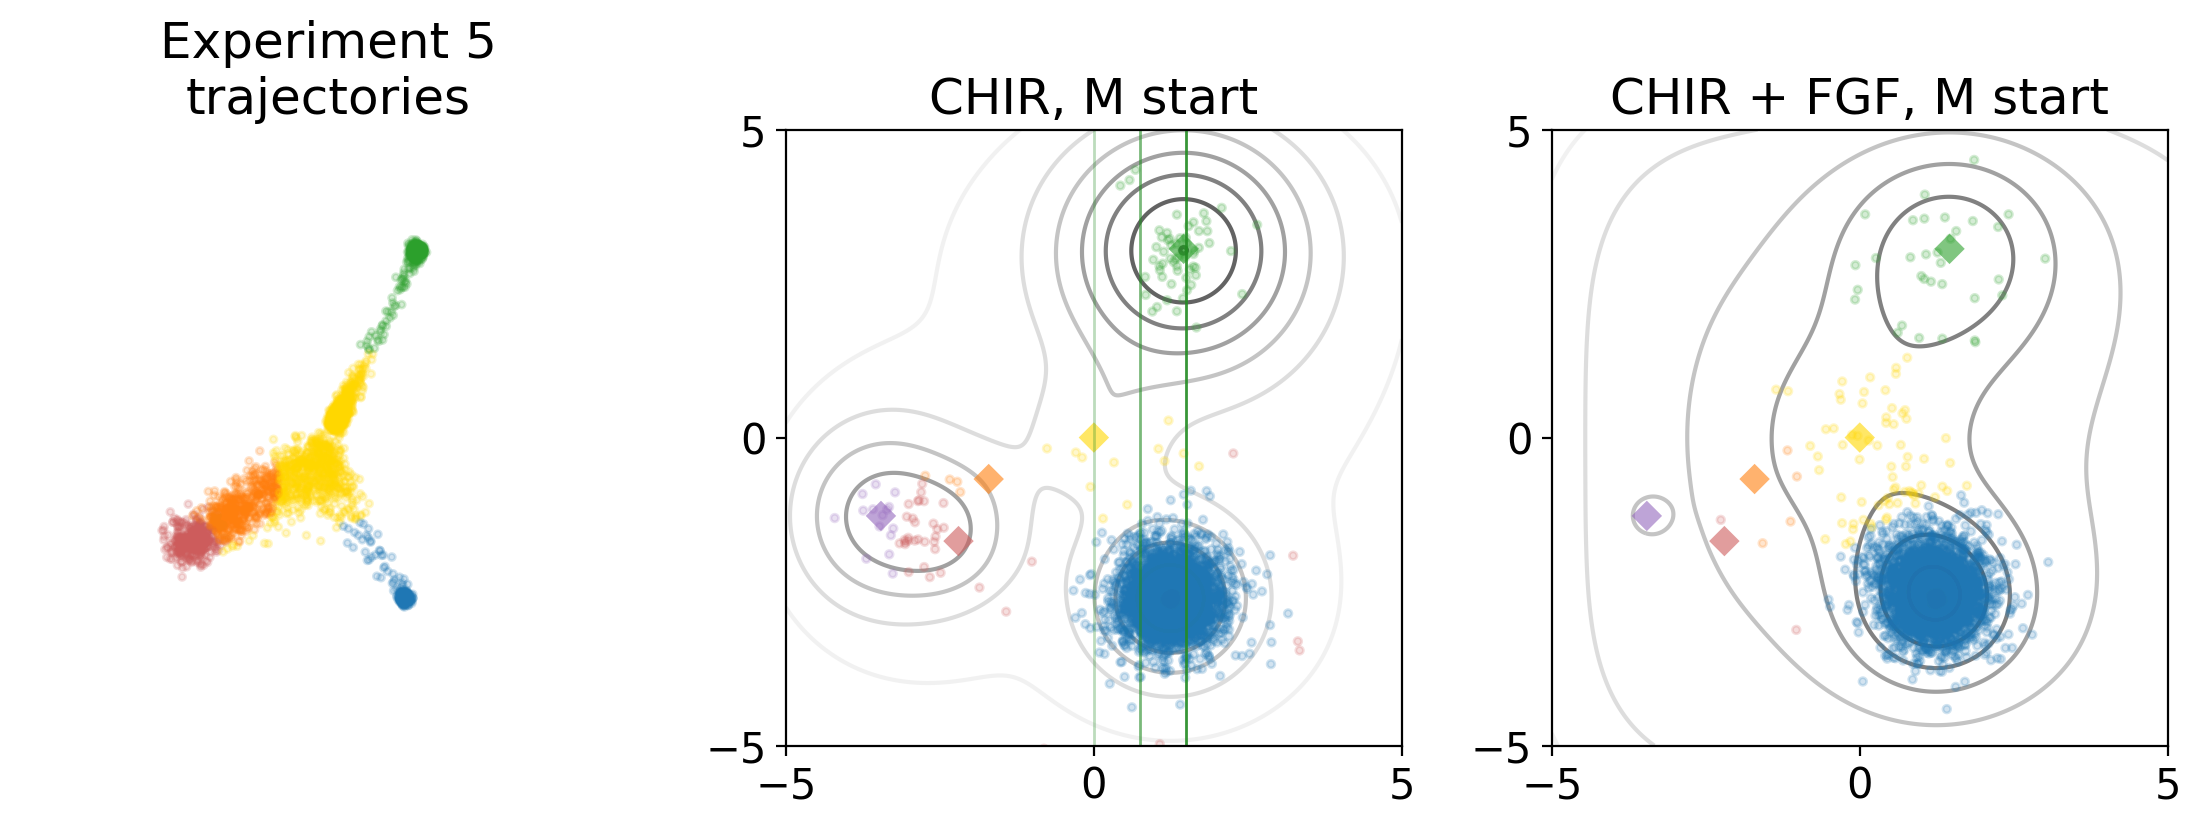

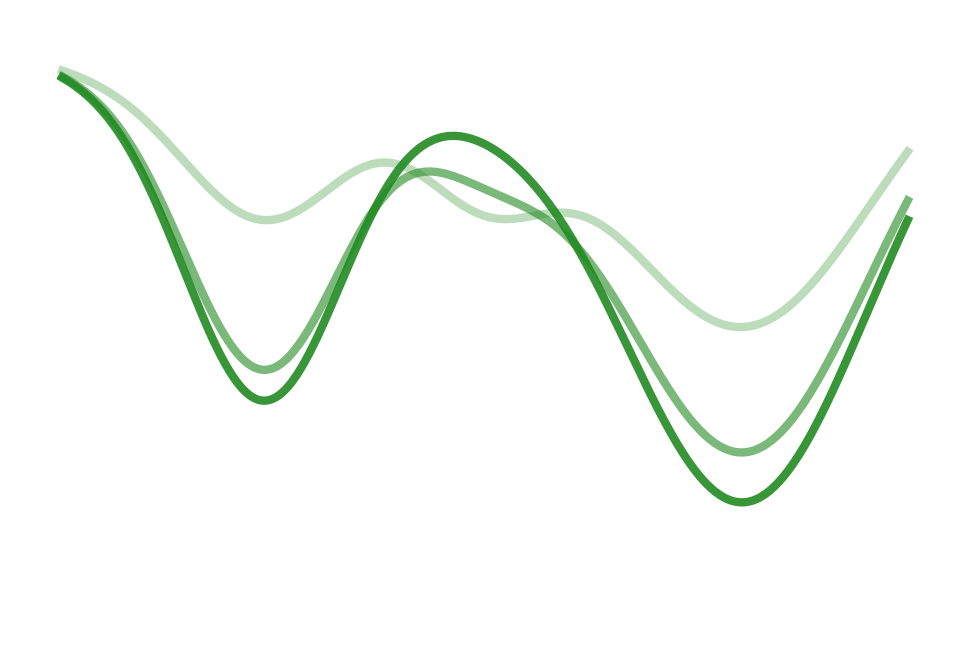

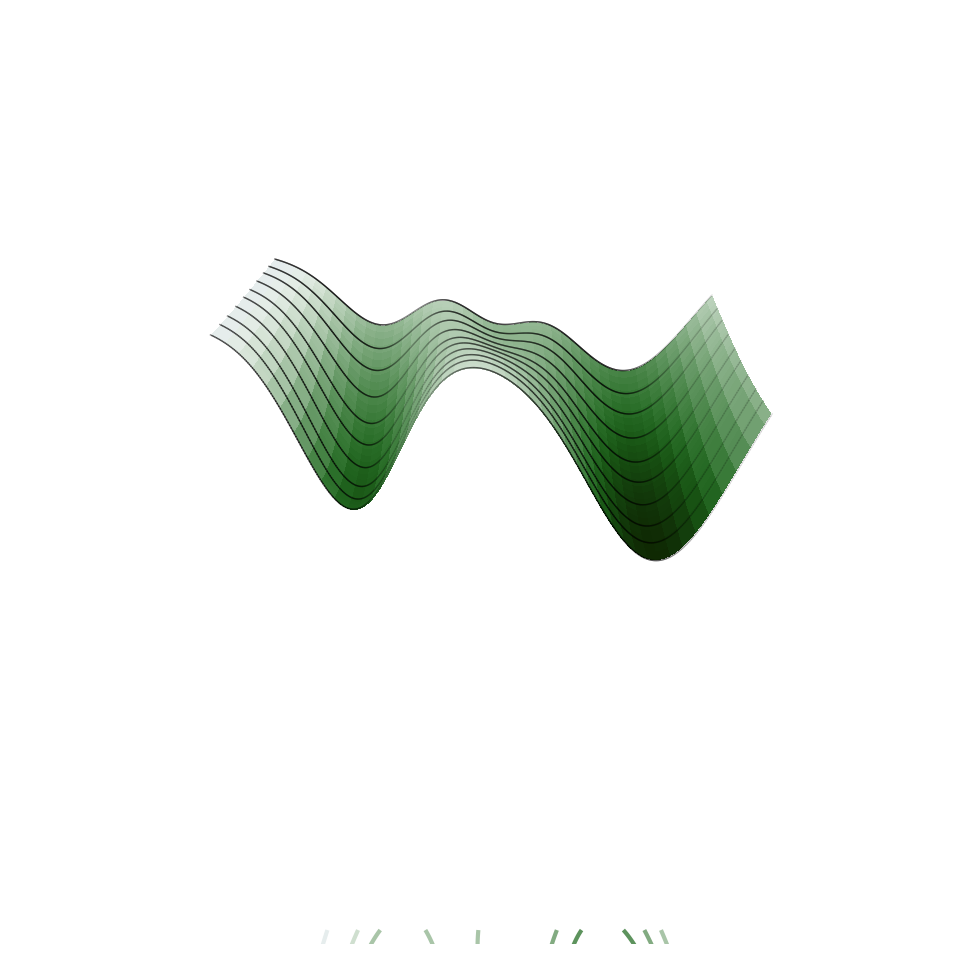

In [21]:
%autoreload

L = 5.
npoints = 401
q = np.linspace(-L, L, npoints)
xx, yy = np.meshgrid(q,q, indexing = 'xy')

colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')
cmap_state = ListedColormap(colors)
norm_state = BoundaryNorm(np.arange(len(colors)+1) - 0.5, cmap_state.N)

noise = 0.2
ndt = 50
nt = 15
ncells = 300


init_state = 2

origin = 2
direction = (3,4)
right = None
bottom = 4
left = 0

delta=2.
# morphogen_times = (delta*1, delta*3, delta*7, delta*7)
# time_pars = (0, delta*7, nt)


morphogen_times = (delta*1, delta*3, delta*7, delta*7)
morphogen_times_1 = (delta*0, delta*7., delta*7, delta*7)  # FGF, no Chir
morphogen_times_2 = (-delta*1, -delta*1., delta*7, delta*7)  # Chir
morphogen_times_3 = (-delta*1, delta*7., delta*9, delta*9)   # Chir + FGF
time_pars_exp = (0, delta*7, 15)


time_pars = (0, delta*5, nt)

n_landscapes = len(timecodes)
# n_landscapes = 58

# for i in (14, 35, 45, 49):   # flips 
# for i in (16, 18, 21, 22, 42, 58):   # choices
# for i in (49,):
for i in (58,):
    
    print(i)
    timecode = timecodes.iloc[i]
    landscape = landscape_from_timecode(timecode, data_dir, gen, landscape_pars)
    landscape.morphogen_times = morphogen_times


    landscape.init_cells(ncells, 0, noise)
    traj, states = landscape.run_cells(*time_pars_exp, noise, ndt=ndt, frozen=False)
    data = traj.transpose().reshape(-1, 2)
    states = states.transpose().reshape(-1, 1)
    st_data = transform_coords(landscape.module_list, data, origin=origin, direction=direction, left=left, right=right, bottom=bottom, scale=False)

    fig, ax = plt.subplots(1,3, figsize=(14,4))
    ax[0].scatter(st_data[:, 0], st_data[:, 1], c=states, cmap=cmap_state, norm=norm_state, s=25, marker='.',  alpha=0.2, edgecolor=None)
    ax[0].set_title('Experiment 5\ntrajectories')

    
    landscape.morphogen_times = morphogen_times_2
    
    
    landscape.init_cells(ncells, 4, noise/5)
    traj, states = landscape.run_cells(*time_pars, noise*8, ndt=ndt, frozen=False)

    data = traj.transpose().reshape(-1, 2)
    states = states.transpose().reshape(-1, 1)
    st_data = transform_coords(landscape.module_list, data, origin=origin, direction=direction, left=left, right=right, bottom=bottom, scale=False)
    ax[1].scatter(st_data[:, 0], st_data[:, 1], c=states, cmap=cmap_state, norm=norm_state, s=30, marker='.',  alpha=0.2, edgecolor=None, edgecolors=None)
    ax[1].set_title('CHIR, M start')

 # _______________________________________________   
    
    landscape.morphogen_times = morphogen_times_3
    landscape.init_cells(ncells, 4, noise/5)
    traj, states = landscape.run_cells(*time_pars, noise*5, ndt=ndt, frozen=False)

    data = traj.transpose().reshape(-1, 2)
    states = states.transpose().reshape(-1, 1)
    st_data = transform_coords(landscape.module_list, data, origin=origin, direction=direction, left=left, right=right, bottom=bottom, scale=False)
    ax[2].scatter(st_data[:, 0], st_data[:, 1], c=states, cmap=cmap_state, norm=norm_state, s=30, marker='.',  alpha=0.2, edgecolor=None, edgecolors=None)
    ax[2].set_title('CHIR + FGF, M start')
    
    
    # plotting potentials 
    
    cmap_signals = cm.batlow
    colors_signals= cmap_signals((0., 0.2, 0.7, 0.4, 0.9))
    
    landscape = rotate_landscape(landscape, origin=origin, direction=direction, left=left, right=right, bottom=bottom)
    derivs, pot, rot = landscape(delta*8., (xx,yy), return_potentials=True)
    
    ax[1].contour(xx, yy, pot, zorder=0, cmap='Greys_r', alpha=0.9)
    # ax[0].streamplot(xx, yy, *derivs,  density=0.3, arrowsize=2., arrowstyle='->', linewidth=1, color='grey', zorder=0)

    fig1, ax1 = plt.subplots(1,1, figsize=(6,4))
    
    # fig2 = vis.visualize_potential(landscape, xx[:, 200:305], yy[:, 200:305], t=delta*8., color_scheme='order', rot_contour=False, elev=20, azim=0, cmap_center=0., offset=50.)
    fig2 = vis.visualize_potential(landscape, xx[:, 200:260], yy[:, 200:260], t=delta*8., color_scheme='order', rot_contour=False, elev=20, azim=0, cmap_center=0., offset=50.)
    
    ax2 = plt.gca()
    ax2.set_proj_type('persp', focal_length=0.25)
    ax2.set_zlim((-25, 5))
    ax2.axis('off')

    # fig2, ax2 = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(6, 6))
    # ax2.view_init(elev=20, azim=0)
    # ls = LightSource(azdeg=90, altdeg=75,)
    # rgb = ls.shade(pot, cm.cork, blend_mode='overlay',  vert_exag=1.)
    # rgb = np.clip(rgb * 1.2, 0, 1)  # brighten image
    # # ax2.plot_surface(xx[:, 200:305], yy[:, 200:305], pot[:, 200:305], shade=True, alpha=0.5, color='tab:green')
    # ax2.plot_surface(xx[:, 200:305], yy[:, 200:305], pot[:, 200:305], facecolors=rgb)

    alphas = np.linspace(0.3, 0.9, 3)
    lines = (npoints*np.linspace(0.5, 0.65, 3)).astype('int')    # 0.5, 0.75, 5 for flip
    for alpha, line in enumerate(lines):
        ax[1].plot((xx[0, line], xx[0, line]), (-L, L), lw=1, c='forestgreen', alpha=alphas[alpha])
        ax1.plot(yy[:, line], pot[:, line]-pot[npoints//2, npoints//2], alpha=alphas[alpha], lw=3, c='forestgreen')
        
    lines = (npoints*np.linspace(0.5, 0.65, 10)).astype('int')   # 0.5, 0.75, 15 for flip
    for line in lines:
        # ax2.scatter(xx[:, line], yy[:, line], pot[:, line]+0.1, alpha=1., c='k', zorder=1000, s=1, marker='.')
        # ax2.plot(xx[:, line], yy[:, line], pot[:, line], alpha=0.5, lw=0.5, c='k', zorder=10, linestyle='-')
        zvals = pot[:, line]
        ydot = derivs[1][:, line]
        normed = (ydot - ydot.min()) / (ydot.max() - ydot.min())
        for i in range(len(zvals) - 1):
            x = [xx[i, line], xx[i+1, line]]
            y = [yy[i, line], yy[i+1, line]]
            z = [zvals[i] + 0.1, zvals[i+1] + 0.1]
            alpha = 0.1 + 0.6 * (normed[i])  # control opacity
            lw = 0.5 #+ 2.5 * normed[i]     # control line thickness
            ax2.plot(x, y, z, color='k', alpha=alpha, linewidth=lw, zorder=10)
        
    derivs, pot, rot = landscape(delta*4., (xx, yy), return_potentials=True)
    ax[2].contour(xx, yy, pot, zorder=0, cmap='Greys_r', alpha=0.9)
    ax2.set_xlim((0,2.5))
    
    ax1.set_ylim((-15,7))
    ax1.set_xlabel(r'Phenotypic coordinate $y$')
    ax1.set_ylabel('Potential')
    ax1.axis('off')
    # ax1.legend()
    ax1.set_xticks((-L, 0, L))
    ax1.set_yticks((0,), labels=('CE',))


    
    
    for axi in ax:
        axi.set_ylim((-L,L))
        axi.set_xlim((-L,L))
        axi.set_yticks((-L, 0, L))
        axi.set_xticks((-L, 0, L))
        axi.set_aspect('equal')
        
    for axi in ax[1:]:
        for im, module in enumerate(landscape.module_list):
            axi.scatter(module.x, module.y, c=colors[im], marker='D', s=60, edgecolor='None', alpha=0.6)
    ax[0].axis('off')
    
    plt.show()


45


/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:272: RuntimeWarning: divide by zero encountered in divide
  -np.sum((coordinate.T - np.array((module.x, module.y))) ** 2, axis=1) / 2. / st ** 2) / st ** 2
/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:271: RuntimeWarning: invalid value encountered in divide
  prob[:, i] = np.exp(
/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)
/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_90358/3633556127.py:9: RuntimeWarning: invalid value encountered in divide
  norm_coords = (module_coords.T/np.linalg.norm(module_coords, axis=1).T).T
/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_90358/289758969.py:11: RuntimeWarning: invalid value encountered in divide
  norm_coords = (module_coords.T/np.linalg.norm(module_coords, axis=1).T).T


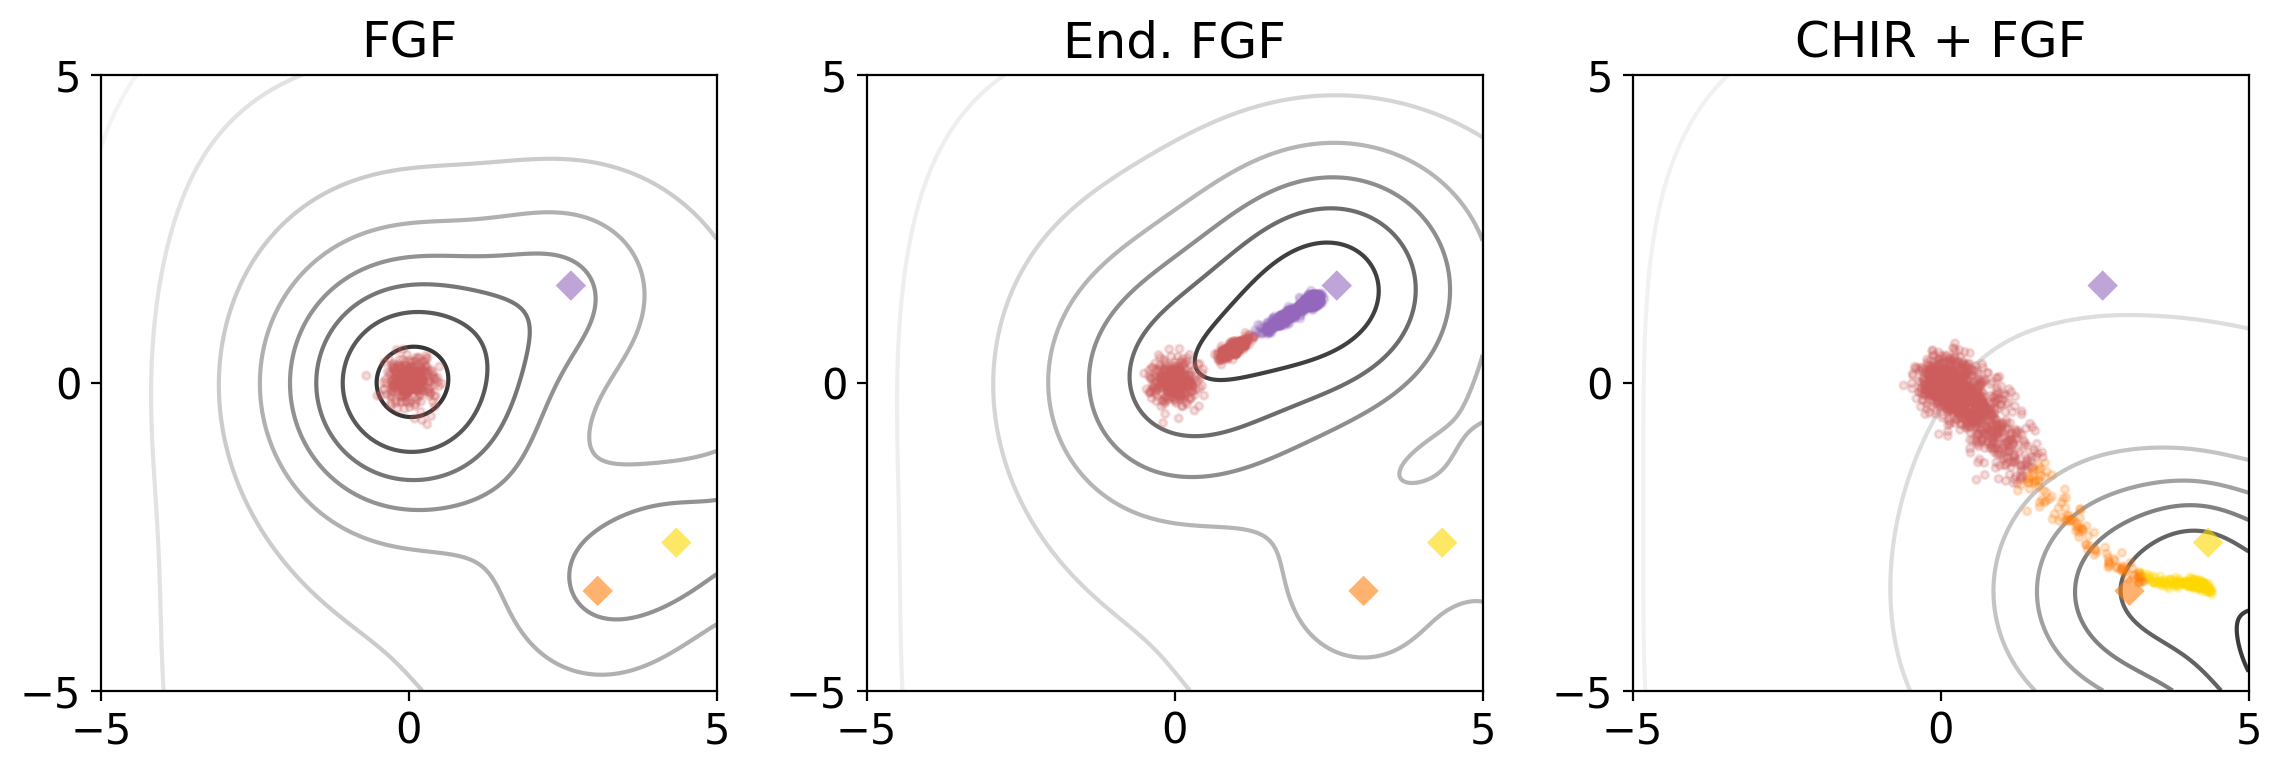

In [297]:
%autoreload

L = 5.
npoints = 401
q = np.linspace(-L, L, npoints)
xx, yy = np.meshgrid(q,q, indexing = 'xy')

colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')
cmap_state = ListedColormap(colors)
norm_state = BoundaryNorm(np.arange(len(colors)+1) - 0.5, cmap_state.N)

noise = 0.2
ndt = 50
nt = 5
ncells = 300


init_state = 0

origin = 0 
direction = (5,2)
right = None
left = None
bottom = 4

delta=2.
# morphogen_times = (delta*1, delta*3, delta*7, delta*7)
# time_pars = (0, delta*7, nt)


morphogen_times = (delta*3, delta*3, delta*3, delta*7)

morphogen_times_1 = (delta*0, delta*0., delta*0, delta*0)  # End. FGF, no Chir
morphogen_times_0 = (delta*7, delta*7., delta*7, delta*7)  # FGF, no Chir

morphogen_times_2 = (-delta*1, delta*7., delta*9, delta*9)   # Chir + FGF
morphogen_times_3 = (-delta*1, -delta*1., delta*7, delta*7)  # Chir


time_pars_exp = (0, delta*2, 15)
time_pars = (0, delta, nt)

n_landscapes = len(timecodes)
# n_landscapes = 58

# for i in (14, 35, 45, 49):   # flips 
# for i in (16, 18, 21, 22, 42, 58):   # choices
# for i in (49,):
for i in (45,):
# for i in range(n_landscapes):
    
    print(i)
    timecode = timecodes.iloc[i]
    landscape = landscape_from_timecode(timecode, data_dir, gen, landscape_pars)
    landscape.morphogen_times = morphogen_times

    fig, ax = plt.subplots(1,3, figsize=(14,4))
    
    landscape.morphogen_times = morphogen_times_0
    
    landscape.init_cells(ncells, 0, noise)
    traj, states = landscape.run_cells(*time_pars, noise, ndt=ndt, frozen=False)

    data = traj.transpose().reshape(-1, 2)
    states = states.transpose().reshape(-1, 1)
    st_data = transform_coords(landscape.module_list, data, origin=origin, direction=direction, left=left, right=right, bottom=bottom, scale=False)
    ax[0].scatter(st_data[:, 0], st_data[:, 1], c=states, cmap=cmap_state, norm=norm_state, s=30, marker='.',  alpha=0.2, edgecolor=None, edgecolors=None)
    ax[0].set_title('FGF')

# _______________________________________________________________________________    
    landscape.morphogen_times = morphogen_times_1
    
    landscape.init_cells(ncells, 0, noise)
    traj, states = landscape.run_cells(*time_pars, noise, ndt=ndt, frozen=False)

    data = traj.transpose().reshape(-1, 2)
    states = states.transpose().reshape(-1, 1)
    st_data = transform_coords(landscape.module_list, data, origin=origin, direction=direction, left=left, right=right, bottom=bottom, scale=False)
    ax[1].scatter(st_data[:, 0], st_data[:, 1], c=states, cmap=cmap_state, norm=norm_state, s=30, marker='.',  alpha=0.2, edgecolor=None, edgecolors=None)
    ax[1].set_title('End. FGF')

 # _______________________________________________   
    
    landscape.morphogen_times = morphogen_times_2
    landscape.init_cells(ncells, 0, noise)
    traj, states = landscape.run_cells(*time_pars, noise*1, ndt=ndt, frozen=False)

    data = traj.transpose().reshape(-1, 2)
    states = states.transpose().reshape(-1, 1)
    st_data = transform_coords(landscape.module_list, data, origin=origin, direction=direction, left=left, right=right, bottom=bottom, scale=False)
    ax[2].scatter(st_data[:, 0], st_data[:, 1], c=states, cmap=cmap_state, norm=norm_state, s=30, marker='.',  alpha=0.2, edgecolor=None, edgecolors=None)
    ax[2].set_title('CHIR + FGF')
    
    # plotting potentials 
    landscape = rotate_landscape(landscape, origin=origin, direction=direction, left=left, right=right, bottom=bottom)
    
    landscape.morphogen_times = morphogen_times_1
    derivs, pot, rot = landscape(delta, (xx,yy), return_potentials=True)
    ax[1].contour(xx, yy, pot, zorder=0, cmap='Greys_r', alpha=0.9)
    
    landscape.morphogen_times = morphogen_times_2
    derivs, pot, rot = landscape(delta, (xx, yy), return_potentials=True)
    ax[2].contour(xx, yy, pot, zorder=0, cmap='Greys_r', alpha=0.9)
    
    landscape.morphogen_times = morphogen_times_0
    derivs, pot, rot = landscape(delta, (xx, yy), return_potentials=True)
    ax[0].contour(xx, yy, pot, zorder=0, cmap='Greys_r', alpha=0.9)
    
    
    for axi in ax:
        axi.set_ylim((-L,L))
        axi.set_xlim((-L,L))
        axi.set_yticks((-L, 0, L))
        axi.set_xticks((-L, 0, L))
        axi.set_aspect('equal')
        
    for axi in ax[:]:
        for im, module in enumerate(landscape.module_list):
            axi.scatter(module.x, module.y, c=colors[im], marker='D', s=60, edgecolor='None', alpha=0.6)
    # ax[0].axis('off')
    
    plt.show()


In [299]:
from evoscape.landscape_visuals import circle_plot
origin = 2
direction = (3,4)
right = None
bottom = 4
left = 0

0


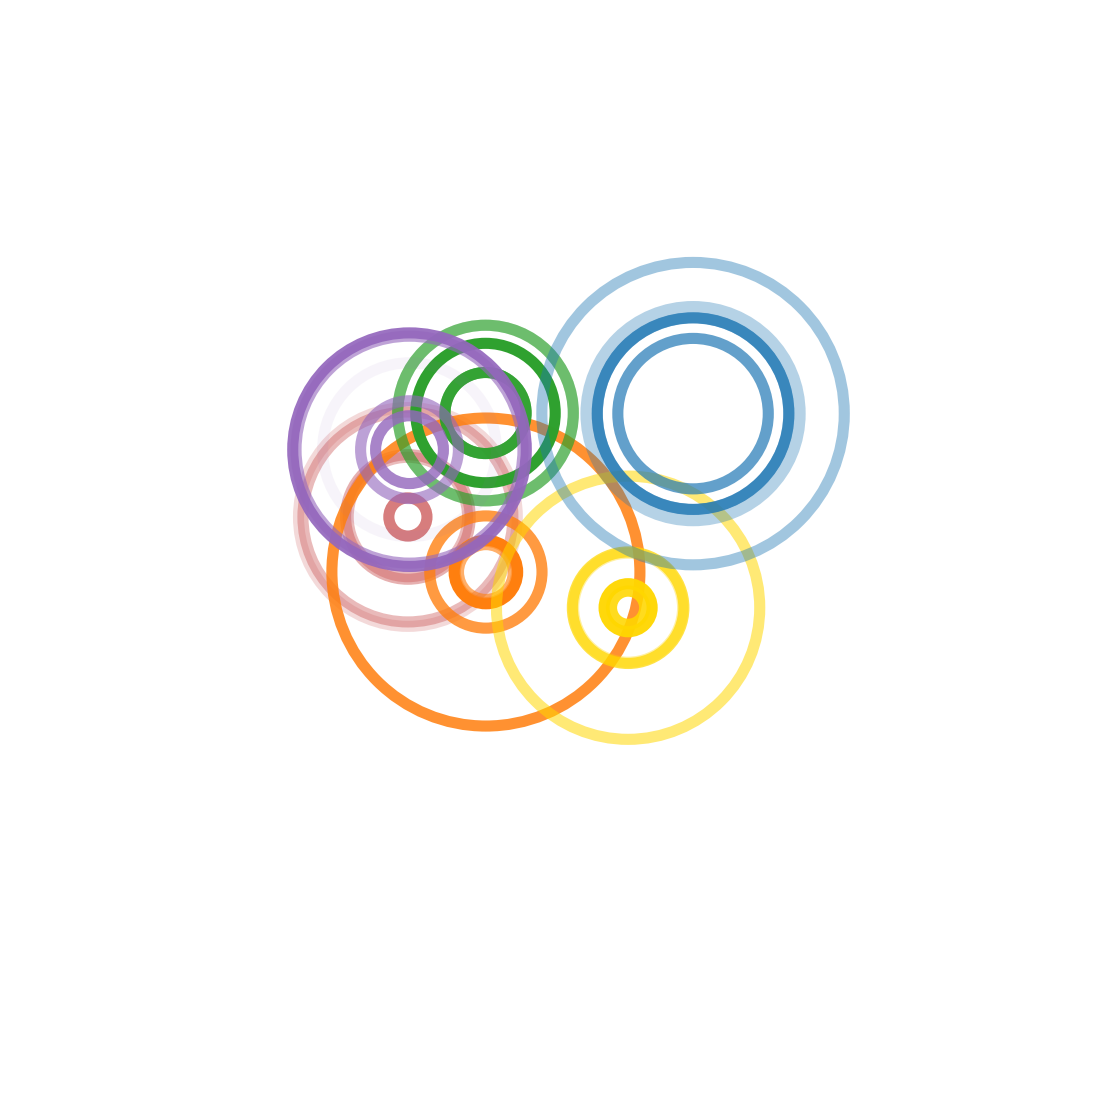

/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_90358/289758969.py:11: RuntimeWarning: invalid value encountered in divide
  norm_coords = (module_coords.T/np.linalg.norm(module_coords, axis=1).T).T


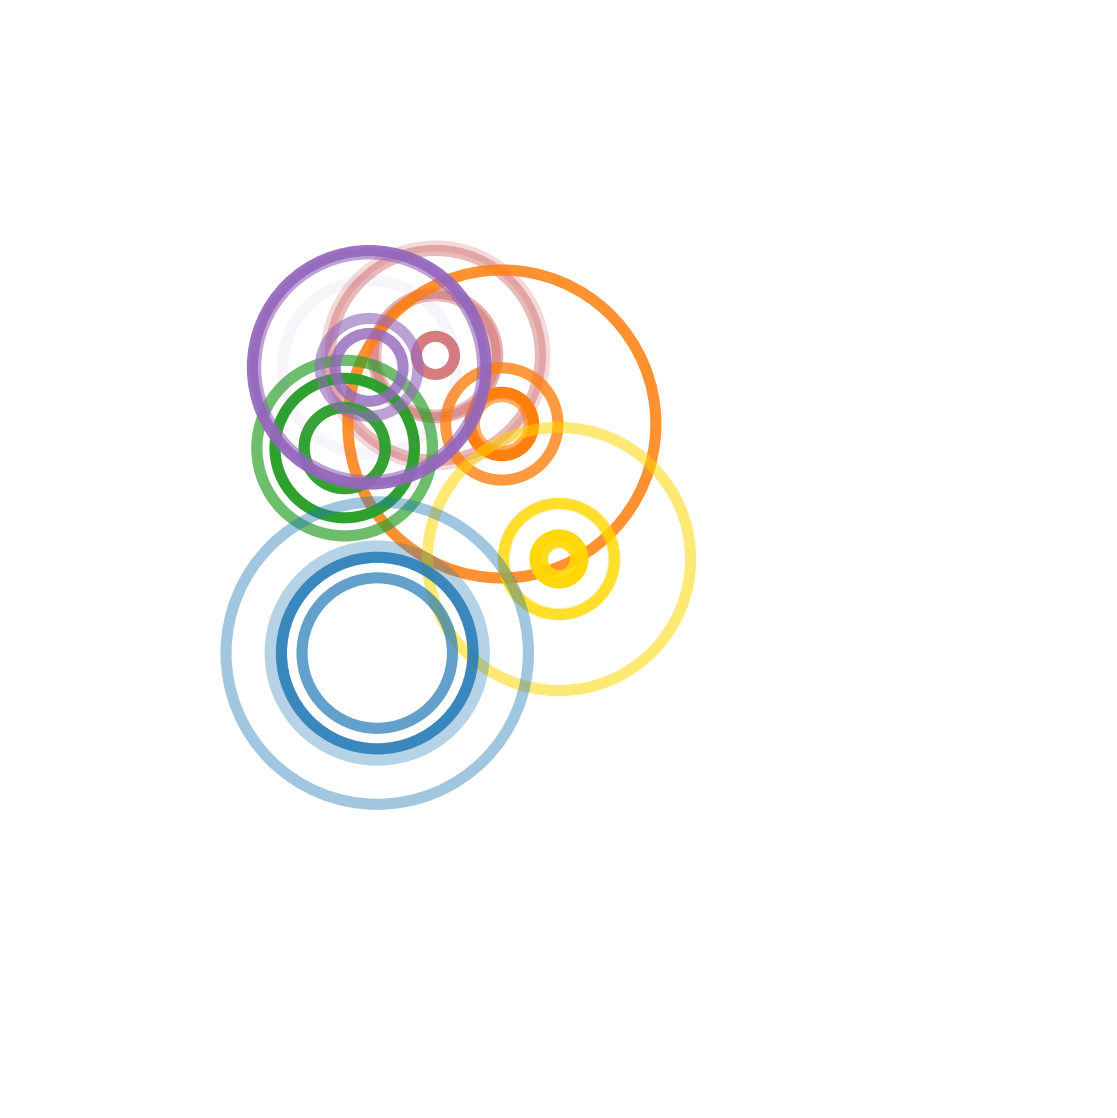

In [301]:

for i in range(n_landscapes//50):
    print(i)
    timecode = timecodes.iloc[i]
    landscape = landscape_from_timecode(timecode, data_dir, gen, landscape_pars)
    fig = circle_plot(landscape)
    plt.show()
    landscape = rotate_landscape(landscape, origin=origin, direction=direction, left=left, right=right, bottom=bottom)
    fig = circle_plot(landscape)
    plt.show()


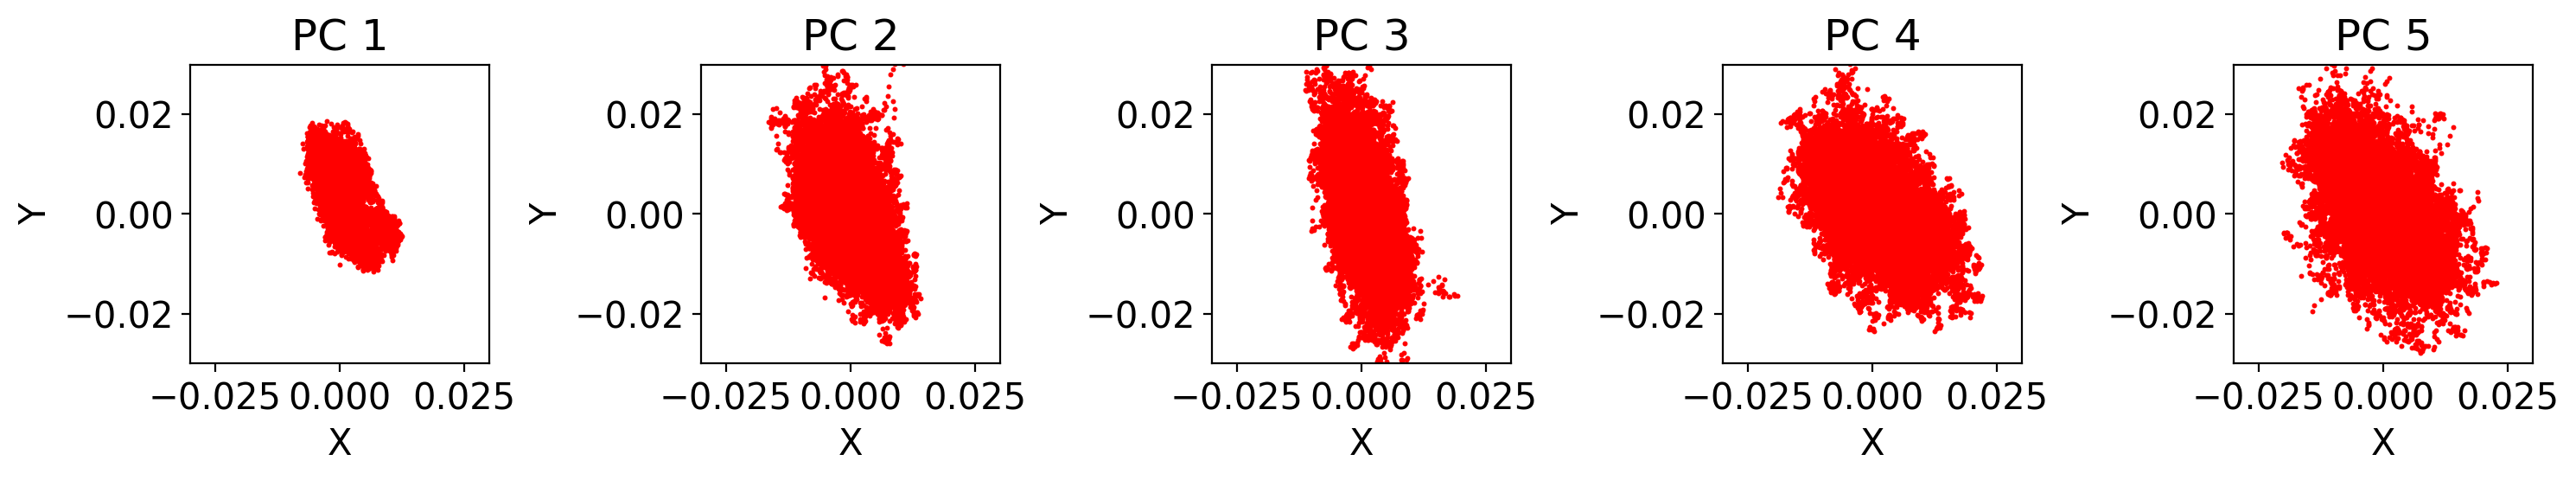

In [47]:
# Number of principal components to visualize
num_components_to_plot = 5

# Reshape PCA components into trajectory format (nt, ncells, 2)
trajectory_shape = (-1, 2)  # Assuming nt * ncells -> trajectory points
pca_components = pca.components_.reshape(num_components_to_plot, *trajectory_shape)

# Plot PCA components as trajectories
plt.figure(figsize=(15, 3))
for i in range(num_components_to_plot):
    plt.subplot(1, num_components_to_plot, i + 1)
    plt.scatter(pca_components[i][:, 0], pca_components[i][:, 1], c='r', marker='.', s = 5)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Principal Component {i+1}")
    plt.xlim((-0.03, 0.03))
    plt.ylim((-0.03, 0.03))
    plt.title(f"PC {i+1}")
    ax = plt.gca()
    ax.set_aspect('equal')
    
plt.tight_layout()
plt.show()

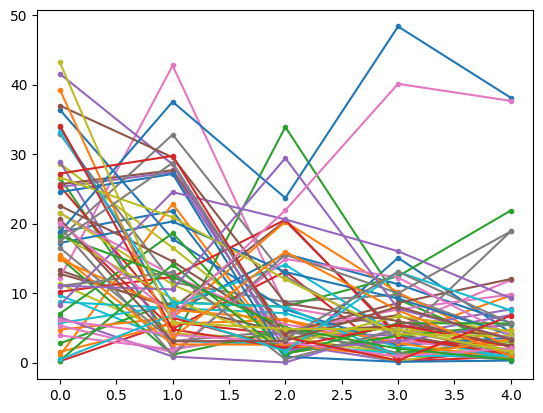

In [65]:
for i in range(n_landscapes):
    plt.plot(np.abs(pca_transformed[i, :5]), '.-')